# **Libraries**

In [388]:
# Databases and Arrays
import pandas as pd 
import numpy as np 

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Time analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# XGB Model
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Darts
from darts import TimeSeries
from darts.models  import RegressionModel
from sklearn.linear_model import LinearRegression



In [389]:
# Plot Style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 5

# Palette
color_pal = sns.color_palette()

# **Data**

Data shows monthly milk production for a company from January 1962 to December 1975

In [390]:
df = pd.read_csv("monthly_milk_production.csv", index_col = "Date", parse_dates = True)

df.sort_index(inplace = True) # Set date as index

df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [391]:
df.info() # Data Info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


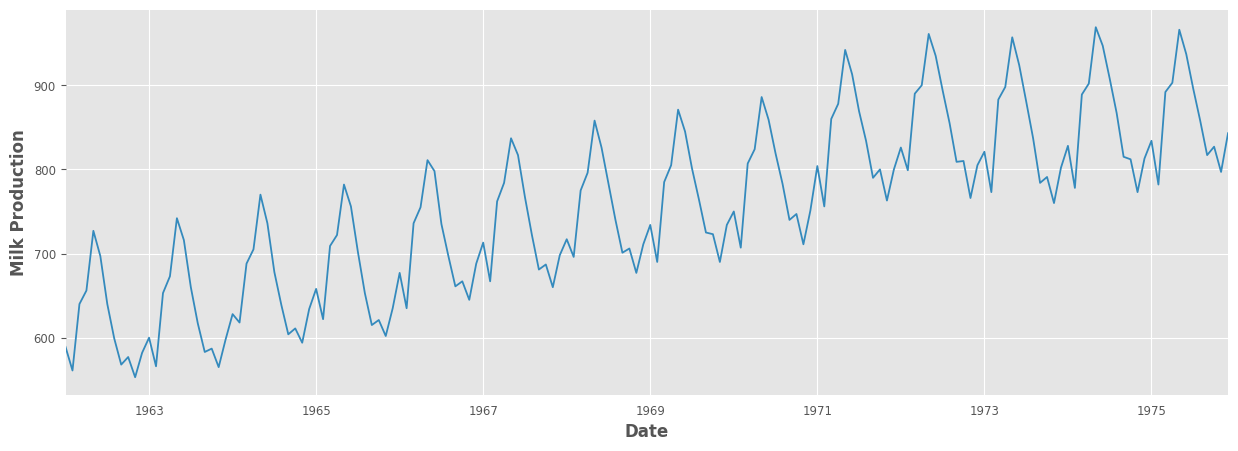

In [392]:
df.plot(color = color_pal[1],
        legend = False)

plt.ylabel("Milk Production")
plt.show()

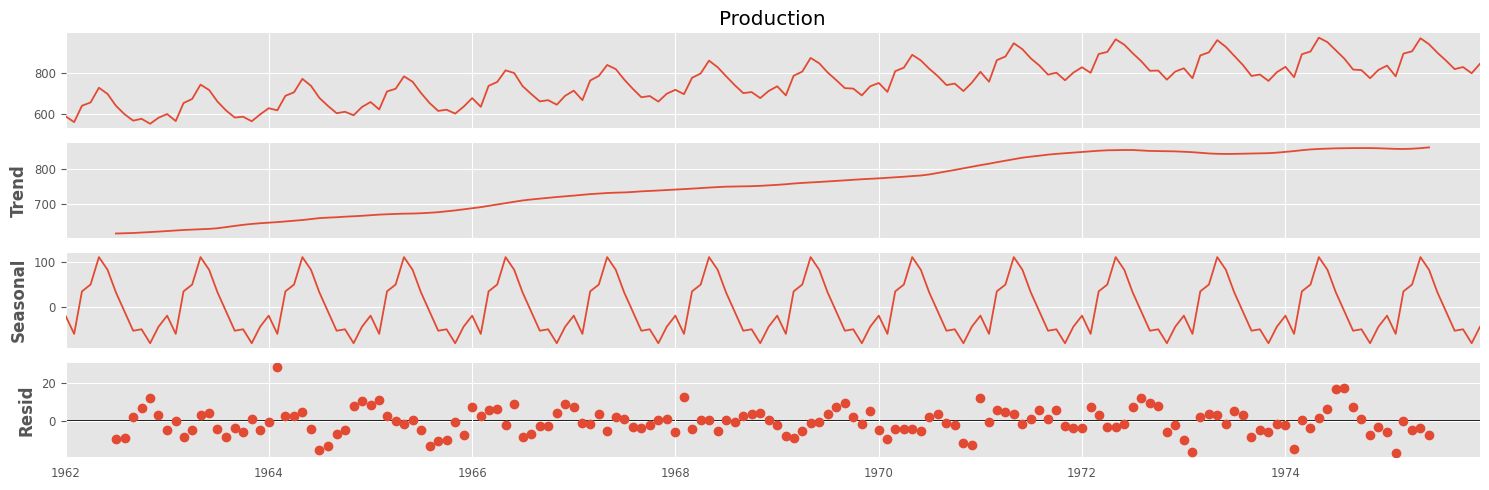

In [393]:
# Seasonal Decompose

res = seasonal_decompose(df["Production"])
res.plot()
plt.show()

In [394]:
#Feature Engineering

df["Year"] = df.index.year
df["Month"] = df.index.month
df.head()

,Production,Year,Month
Date,,,
1962-01-01,589,1962,1
1962-02-01,561,1962,2
1962-03-01,640,1962,3
1962-04-01,656,1962,4
1962-05-01,727,1962,5


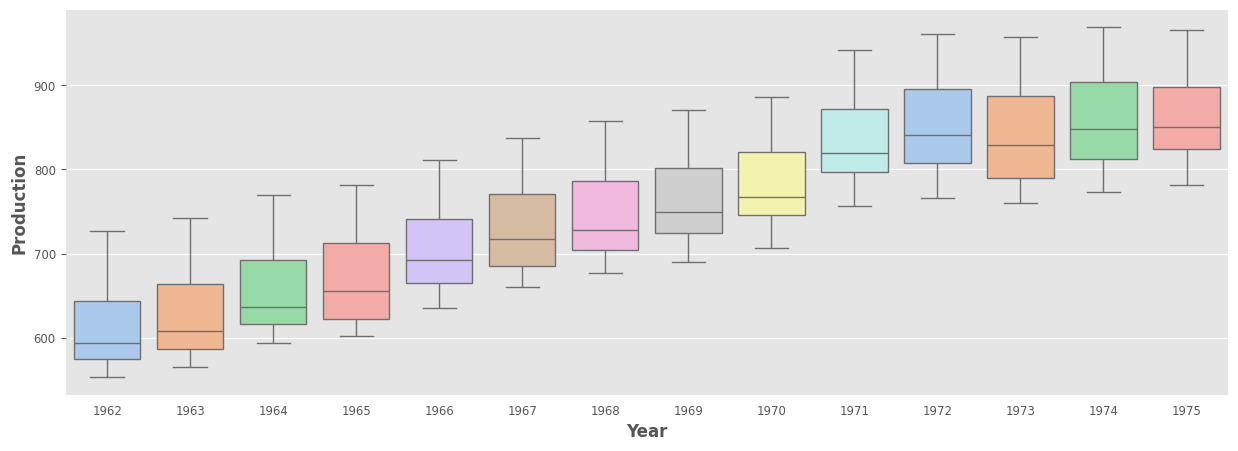

In [395]:
# Yearly Distribution

sns.boxplot(data = df, x = "Year", y = "Production", palette = "pastel", hue = "Year", legend = False)
plt.show()

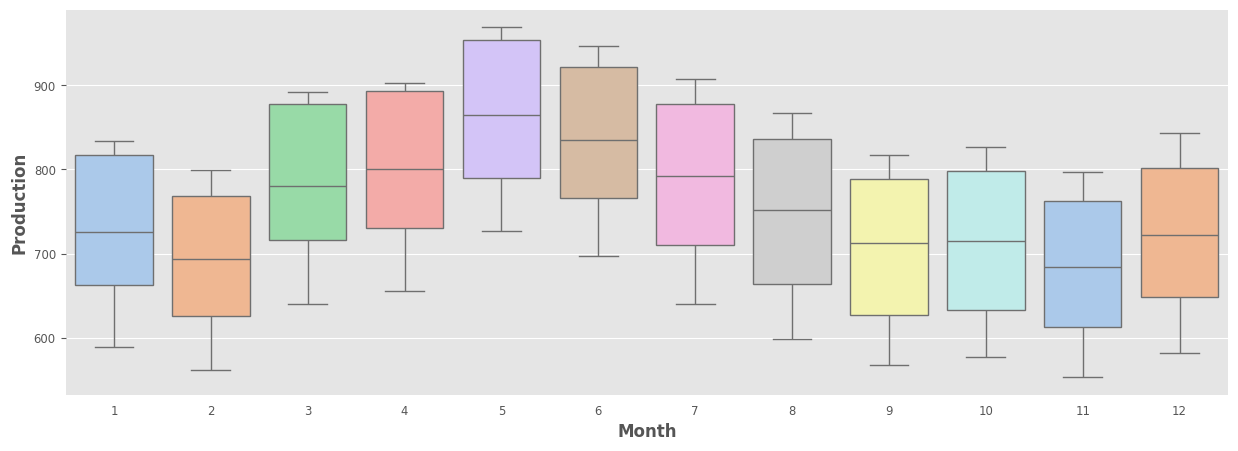

In [396]:
# Monthly Distribution

sns.boxplot(data = df, x = "Month", y = "Production", palette = "pastel", hue = "Month", legend = False)
plt.show()

In [397]:
total_months = len(df)
total_months

168

# **XGBoost**

## Train & Test

In [398]:
train_XGB = df.iloc[:total_months - 12] # Data without last 12 months
test_XGB = df.iloc[total_months - 12:] # Last 12 months

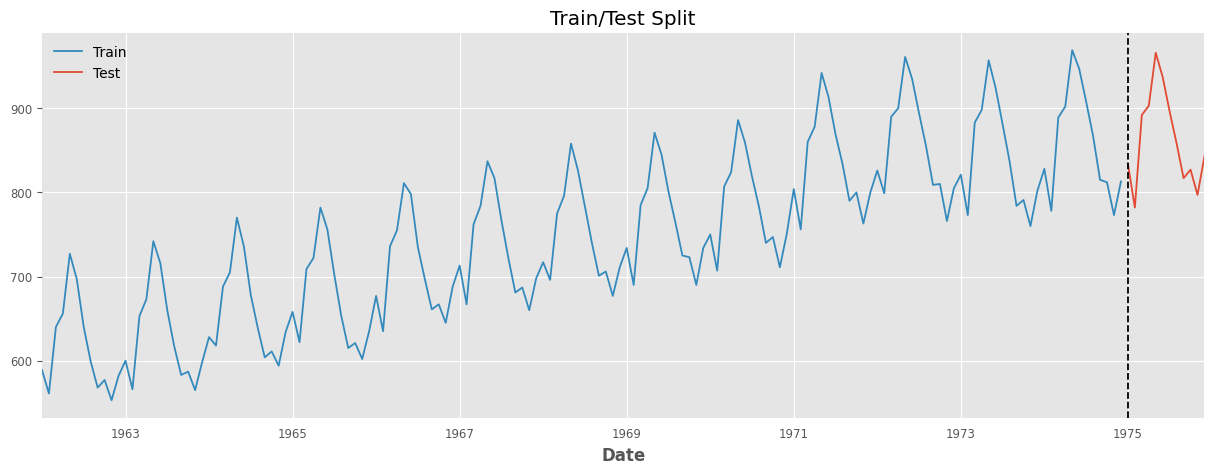

In [399]:
fig, ax = plt.subplots()

train_XGB["Production"].plot(ax = ax , label = "Training Set", color = color_pal[1])
test_XGB["Production"].plot(ax = ax, label = "Test Set", color = color_pal[0])

ax.axvline("1975-01-01", color = "black", ls = "--")
plt.title("Train/Test Split") 
plt.legend(["Train", "Test"])

plt.show()

In [400]:
df.columns

Index(['Production', 'Year', 'Month'], dtype='object')

In [401]:
Features = ["Year", "Month"]
Target = "Production"

X_train = train_XGB[Features]
y_train = train_XGB[Target]

X_test = test_XGB[Features]
y_test = test_XGB[Target]

## Model

In [402]:
#XGB Model
reg = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_round = 50,
                        learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:91.29437	validation_1-rmse:117.71247
[100]	validation_0-rmse:1.18155	validation_1-rmse:13.20779
[200]	validation_0-rmse:0.38288	validation_1-rmse:13.22804
[300]	validation_0-rmse:0.11934	validation_1-rmse:13.22927
[400]	validation_0-rmse:0.04176	validation_1-rmse:13.23423


c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.01231	validation_1-rmse:13.23194
[600]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[700]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[800]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[900]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[999]	validation_0-rmse:0.01169	validation_1-rmse:13.23199


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance

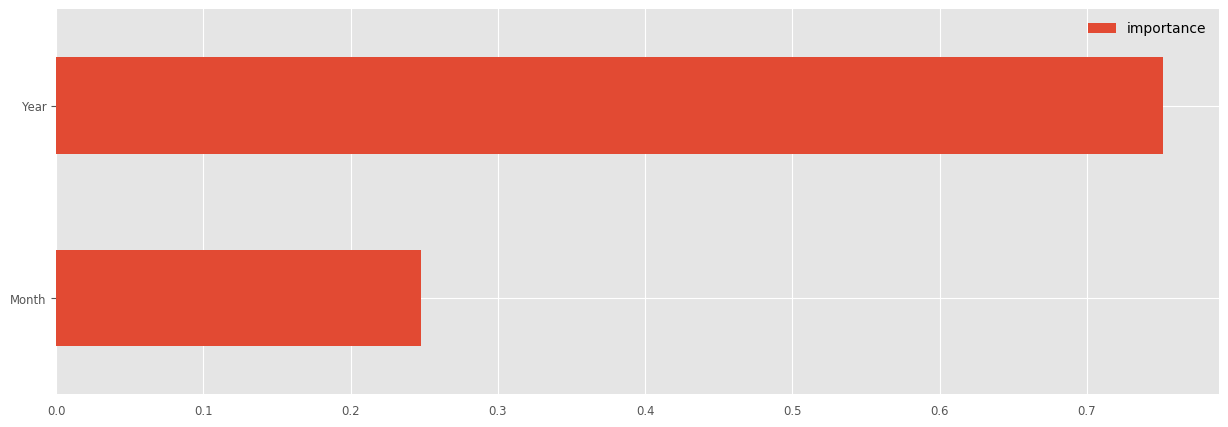

In [403]:
fi = pd.DataFrame(data = reg.feature_importances_,
                index = reg.feature_names_in_,
                columns = ["importance"])


fi.sort_values(by = "importance").plot(kind = "barh")
plt.show()

## Forecast

In [404]:
test_XGB["prediction"] = reg.predict(X_test)
test_XGB.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2463057011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_XGB["prediction"] = reg.predict(X_test)


,Production,Year,Month,prediction
Date,,,,
1975-01-01,834,1975,1,828.000488
1975-02-01,782,1975,2,777.995850
1975-03-01,892,1975,3,889.000610
1975-04-01,903,1975,4,902.007385
1975-05-01,966,1975,5,968.991699


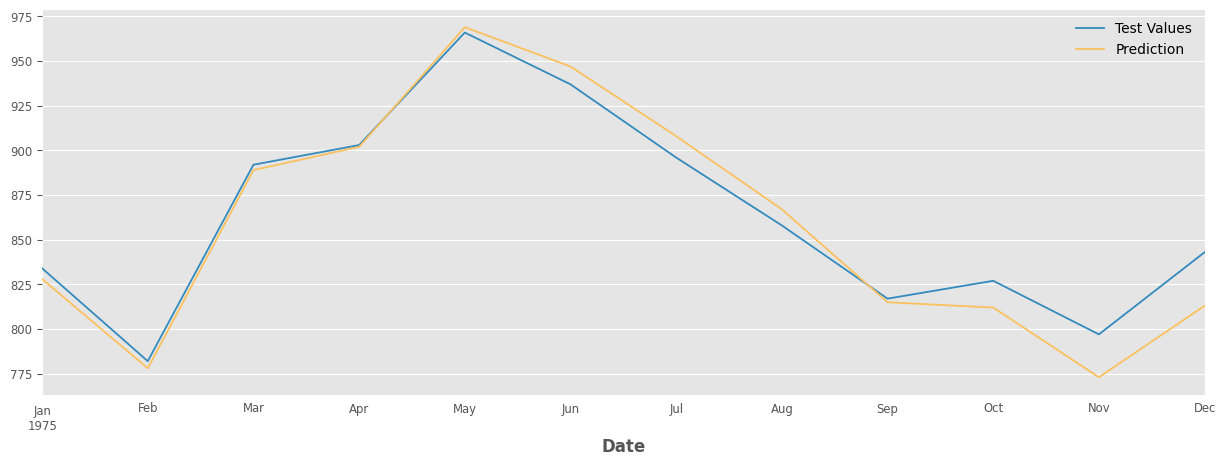

In [405]:
fig, ax = plt.subplots()

test_XGB["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test_XGB["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [406]:
# RMSE

rmse_XGB = root_mean_squared_error(test_XGB["Production"], test_XGB["prediction"])  
rmse_XGB

13.231994052260703

In [407]:
# Automation function

def date_values_XGB(df, months):


        train_XGB = df[:total_months - months]
        test_XGB = df[total_months - months:]

        Features = ["Year", "Month"]
        Target = "Production"

        X_train = train_XGB[Features]
        y_train = train_XGB[Target]

        X_test = test_XGB[Features]
        y_test = test_XGB[Target]

        reg = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_round = 50,
                        learning_rate = 0.1)

        reg.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)], verbose = None)

        test_XGB["prediction"] = reg.predict(X_test)

        rmse_XGB = root_mean_squared_error(test_XGB["Production"], test_XGB["prediction"])

        return  rmse_XGB

In [408]:
date_list = np.arange(12, 84, 12) # Predict from 12 to 74 months

In [409]:
rsme_XGB_dict = {}


for i in date_list:

    rsme_XGB_dict[i] = date_values_XGB(df, i)

rsme_XGB_dict

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acast\AppData\Local\Temp\ipykernel_11840\3678202156.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_XGB["prediction"] = reg.predict(X_test)
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src

{12: 13.231994052260703,
 24: 21.239434390886515,
 36: 13.6748789553015,
 48: 23.45827883281995,
 60: 69.68991476110591,
 72: 80.22861586650448}

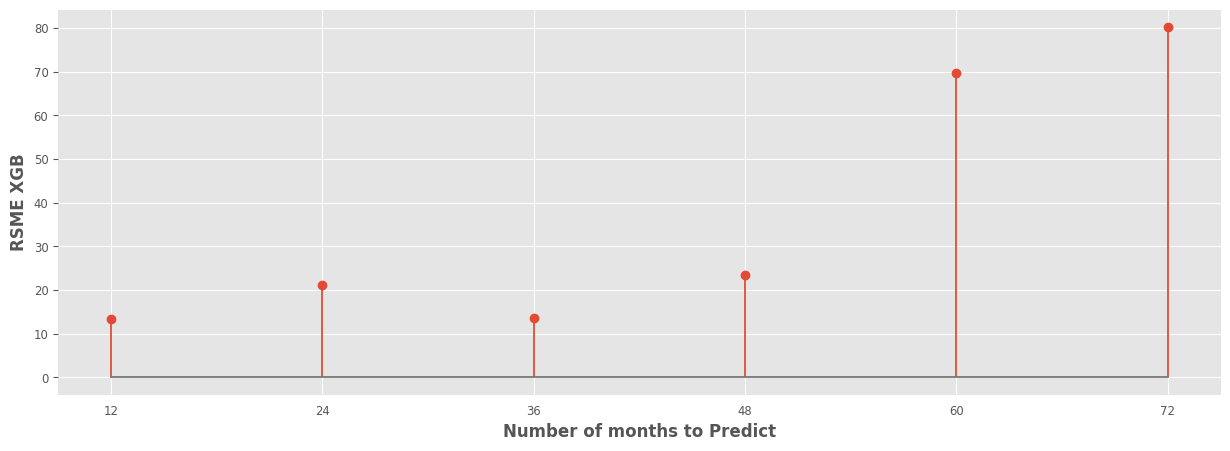

In [410]:
plt.stem(pd.DataFrame.from_dict(data =  rsme_XGB_dict, orient = "index").reset_index()["index"], pd.DataFrame.from_dict(data =  rsme_XGB_dict, orient = "index").reset_index()[0])

plt.ylabel("RSME XGB")
plt.xlabel("Number of months to Predict")
plt.xticks(date_list)
plt.show()

# **LSTM**

In [411]:
df_lstm = df[["Production"]] # Original Data without Additional Features

df_lstm.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [412]:
train_LSTM = df_lstm.iloc[:total_months - 12] # Data without last 12 months
test_LSTM = df_lstm.iloc[total_months - 12:] # Last 12 months

In [413]:
scaler = MinMaxScaler() # Set values between 0-1

# Fit
scaler.fit(df_lstm)

# Transform tran and test data
scaled_train = scaler.transform(train_LSTM)
scaled_test = scaler.transform(test_LSTM)

In [414]:
n_input = 12 # Use the last 12 months to predict the next month
n_features = 1 # Take into accoount Production feature

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [415]:
# Neural Network

model = Sequential()
model.add(LSTM(100, activation = "relu", input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mse")

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [416]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [417]:
model.fit(generator, epochs = 50)

Epoch 1/50
 53/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1524

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0934
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035


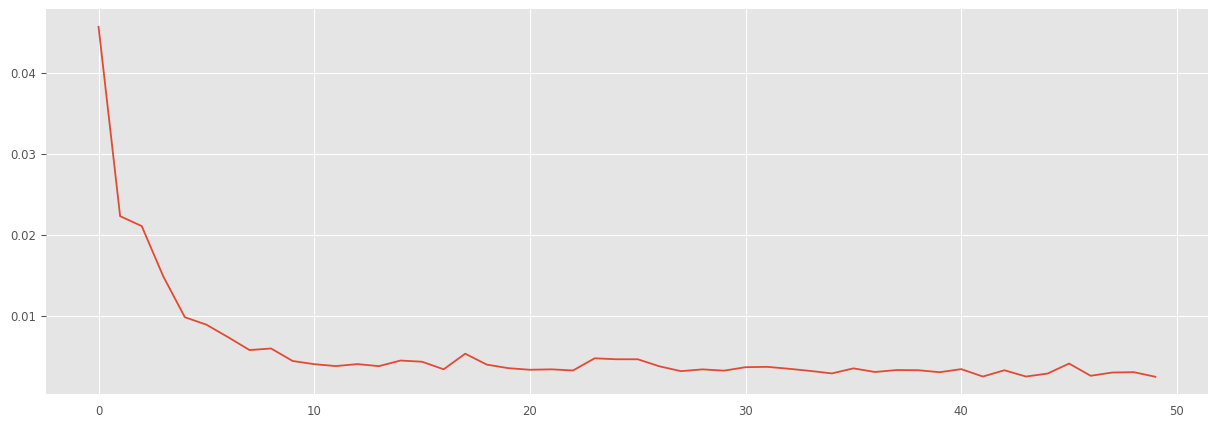

In [418]:
#Plot Loss

loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [419]:
# Predict a next month

last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


array([[0.65002286]], dtype=float32)

In [420]:
# Predict whole test data

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_LSTM)):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [421]:
# Append predictions to test data

true_predictions = scaler.inverse_transform(test_predictions) # Remove Scaler Operation
test_LSTM["prediction"] = true_predictions
test_LSTM.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2435023584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions


,Production,prediction
Date,,
1975-01-01,834,823.409512
1975-02-01,782,827.141933
1975-03-01,892,893.537054
1975-04-01,903,925.970379
1975-05-01,966,970.299038


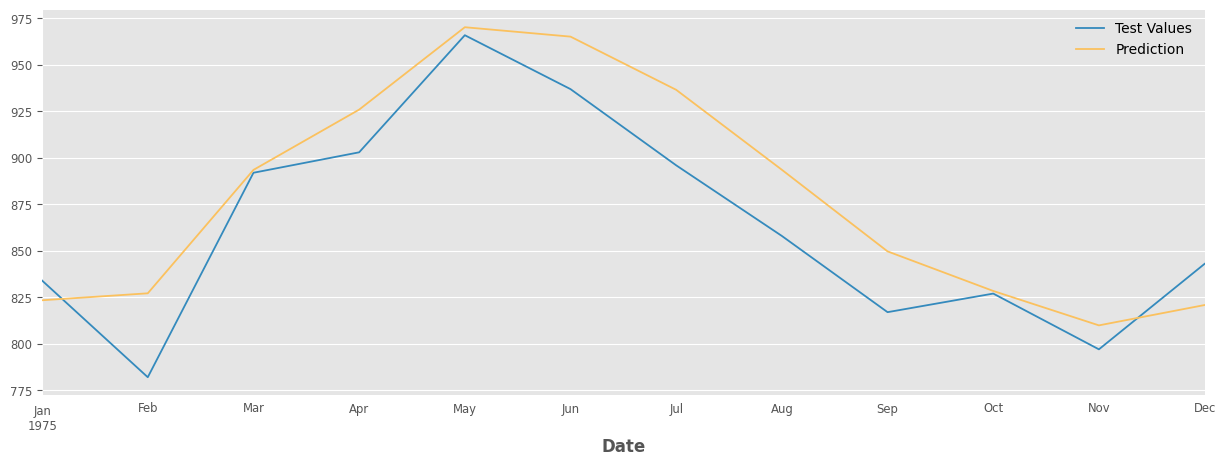

In [422]:
# Plot Data

fig, ax = plt.subplots()

test_LSTM["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test_LSTM["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [423]:
# RMSE

rsme_LSTM = root_mean_squared_error(test_LSTM["Production"], test_LSTM["prediction"])  
rsme_LSTM

26.04847578093297

In [424]:
# Automation function

def date_value_LSTM(df, months):

        train_LSTM = df[:total_months - months]
        test_LSTM = df[total_months - months:]

        scaler = MinMaxScaler()
        scaler.fit(df)
        scaled_train = scaler.transform(train_LSTM)
        scaled_test = scaler.transform(test_LSTM)

        n_input = months
        n_features = 1

        generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

        model = Sequential()
        model.add(LSTM(100, activation = "relu", input_shape = (n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer = "adam", loss = "mse")

        model.fit(generator, epochs = 30)

        test_predictions = []

        first_eval_batch = scaled_train[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        for i in range(len(test_LSTM)):
            current_pred = model.predict(current_batch)[0]

            test_predictions.append(current_pred)
            
            current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

        true_predictions = scaler.inverse_transform(test_predictions) # Remove Scaler Operation
        test_LSTM["prediction"] = true_predictions

        rsme_LSTM = root_mean_squared_error(test_LSTM["Production"], test_LSTM["prediction"]) 

        return  rsme_LSTM

In [425]:
rsme_LSTM_dict = {}


for i in date_list:

    rsme_LSTM_dict[i] = date_value_LSTM(df_lstm, i)

rsme_LSTM_dict

Epoch 1/30


c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 51/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2112

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1231
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 13/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 14/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 15/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031


C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 32/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1767

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0912
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0353
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 9/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 10/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoch 11/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090
Epoch 12/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 13/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 14/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 15/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056


C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1840

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1113
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0243
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0233
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 10/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064
Epoch 11/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 12/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090
Epoch 13/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079
Epoch 14/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098
Epoch 15/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 16/30
96/96 ━━━━━━━━━━━━

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1423

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0899
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0184
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0269
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222
Epoch 9/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210
Epoch 10/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0191
Epoch 11/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0211
Epoch 12/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203
Epoch 13/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244
Epoch 14/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182
Epoch 15/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219
Epoch 16/30
72/72 ━━━━━━━━━━━━

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/48 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1627

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0965
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0229
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0256
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0191
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164
Epoch 12/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174
Epoch 13/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164
Epoch 14/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140
Epoch 15/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 16/30
48/48 ━━━━━━━━━━━━

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1698

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1453
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0303
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0232
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175  
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0248
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0205
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193
Epoch 16/30
24/24 ━━━━━━

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\2220171441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_LSTM["prediction"] = true_predictions


{12: 33.74172533552351,
 24: 76.3037775670421,
 36: 100.95521008744043,
 48: 89.57112447087957,
 60: 112.21440736222398,
 72: 90.47785768742094}

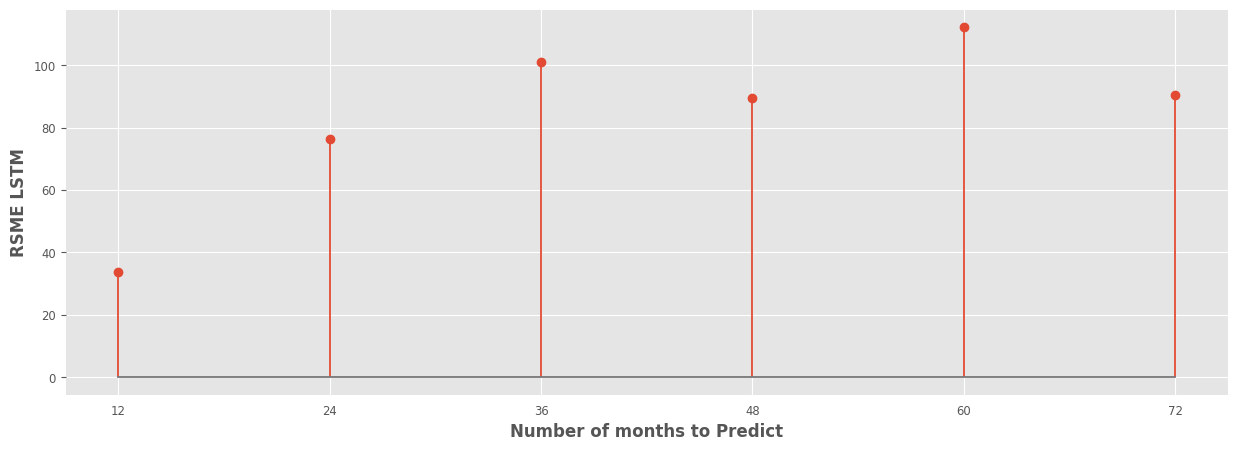

In [426]:
plt.stem(pd.DataFrame.from_dict(data =  rsme_LSTM_dict, orient = "index").reset_index()["index"], pd.DataFrame.from_dict(data =  rsme_LSTM_dict, orient = "index").reset_index()[0])

plt.ylabel("RSME LSTM")
plt.xlabel("Number of months to Predict")
plt.xticks(date_list)
plt.show()

# **Darts**

In [427]:
# Time Series for Darts

y = TimeSeries.from_series(df["Production"])
y[:10]

<TimeSeries (DataArray) (Date: 10, component: 1, sample: 1)> Size: 80B
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 80B 1962-01-01 1962-02-01 ... 1962-10-01
  * component  (component) object 8B 'Production'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [428]:
# Train data
y_train = y[:total_months - 12]
test_darts = df[total_months - 12:]

In [429]:
model_darts = RegressionModel(lags = [-12],
                        model = LinearRegression())

model_darts.fit(series = y_train)

RegressionModel(lags=[-12], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=LinearRegression(), multi_models=True, use_static_covariates=True)

In [430]:
y_predict = model_darts.predict(n = 24, series = y_train)

y_predict.pd_series()

Date
1975-01-01    845.328317
1975-02-01    796.919589
1975-03-01    904.386965
1975-04-01    916.973234
1975-05-01    981.840929
1975-06-01    960.541089
1975-07-01    922.782281
1975-08-01    883.087125
1975-09-01    832.742048
1975-10-01    829.837524
1975-11-01    792.078716
1975-12-01    830.805699
1976-01-01    862.105152
1976-02-01    815.237054
1976-03-01    919.284233
1976-04-01    931.469938
1976-05-01    994.273190
1976-06-01    973.651227
1976-07-01    937.094110
1976-08-01    898.662269
1976-09-01    849.919447
1976-10-01    847.107361
1976-11-01    810.550244
1976-12-01    848.044723
Freq: MS, Name: Production, dtype: float64

In [431]:
test_darts["prediction"] = y_predict.pd_series()

test_darts.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_11840\3888640669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_darts["prediction"] = y_predict.pd_series()


,Production,Year,Month,prediction
Date,,,,
1975-01-01,834,1975,1,845.328317
1975-02-01,782,1975,2,796.919589
1975-03-01,892,1975,3,904.386965
1975-04-01,903,1975,4,916.973234
1975-05-01,966,1975,5,981.840929


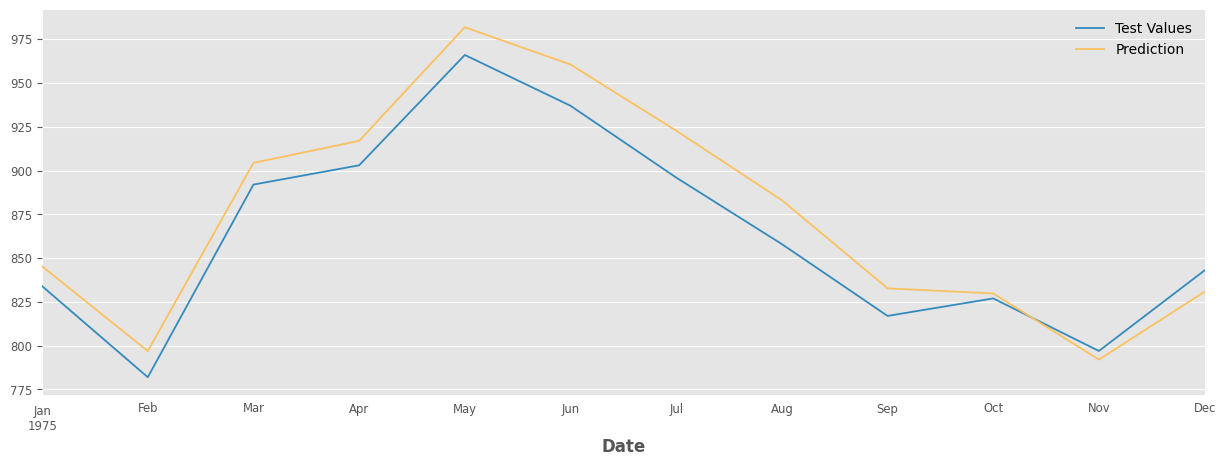

In [432]:
fig, ax = plt.subplots()

test_darts["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test_darts["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [433]:
# RMSE

rmse_darts = root_mean_squared_error(test["Production"], test["prediction"])  
rmse_darts

23.844404097656987

In [434]:
# Automation function

def date_values_darts(df, months):
    months = int(months)
    y = TimeSeries.from_series(df["Production"])
    print(len(y))
    y_train = y[:total_months - months]
    
    test_darts = df[total_months - months:]

    model_darts = RegressionModel(lags = [-months],
                        model = LinearRegression())

    model_darts.fit(series = y_train)

    y_predict = model_darts.predict(n = months, series = y_train)

    test_darts["prediction"] = y_predict.pd_series()

    rmse_dart = root_mean_squared_error(test_darts["Production"], test_darts["prediction"])

    return  rmse_darts

In [435]:
rsme_darts_dict = {}

for i in date_list:
    rsme_darts_dict[i] = date_values_darts(df, i)

rsme_darts_dict

168
168
168
168
168
168


C:\Users\acast\AppData\Local\Temp\ipykernel_11840\3893928678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_darts["prediction"] = y_predict.pd_series()
C:\Users\acast\AppData\Local\Temp\ipykernel_11840\3893928678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_darts["prediction"] = y_predict.pd_series()
C:\Users\acast\AppData\Local\Temp\ipykernel_11840\3893928678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

{12: 23.844404097656987,
 24: 23.844404097656987,
 36: 23.844404097656987,
 48: 23.844404097656987,
 60: 23.844404097656987,
 72: 23.844404097656987}

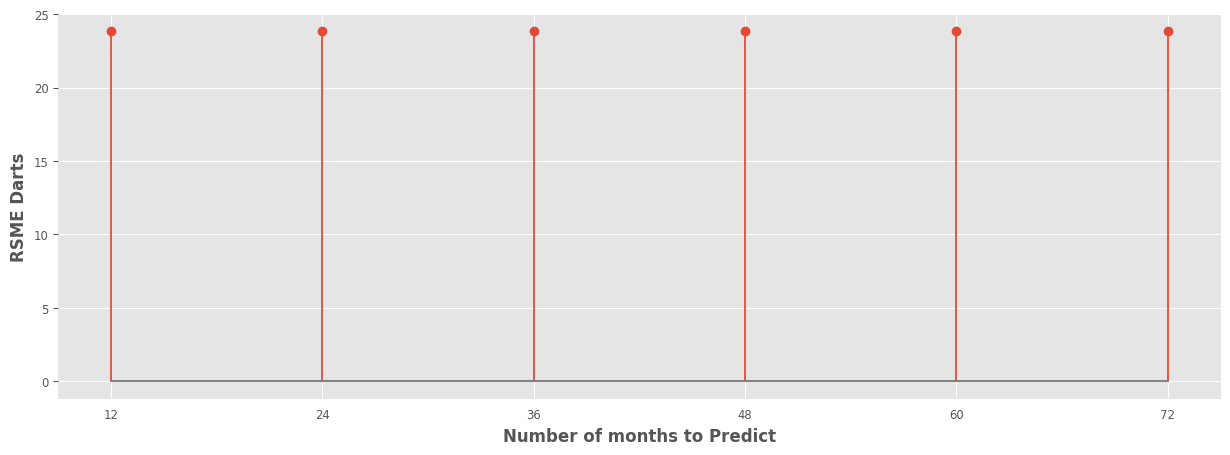

In [436]:
plt.stem(pd.DataFrame.from_dict(data =  rsme_darts_dict, orient = "index").reset_index()["index"], pd.DataFrame.from_dict(data =  rsme_darts_dict, orient = "index").reset_index()[0])

plt.ylabel("RSME Darts")
plt.xlabel("Number of months to Predict")
plt.xticks(date_list)
plt.show()

# **Comparison**

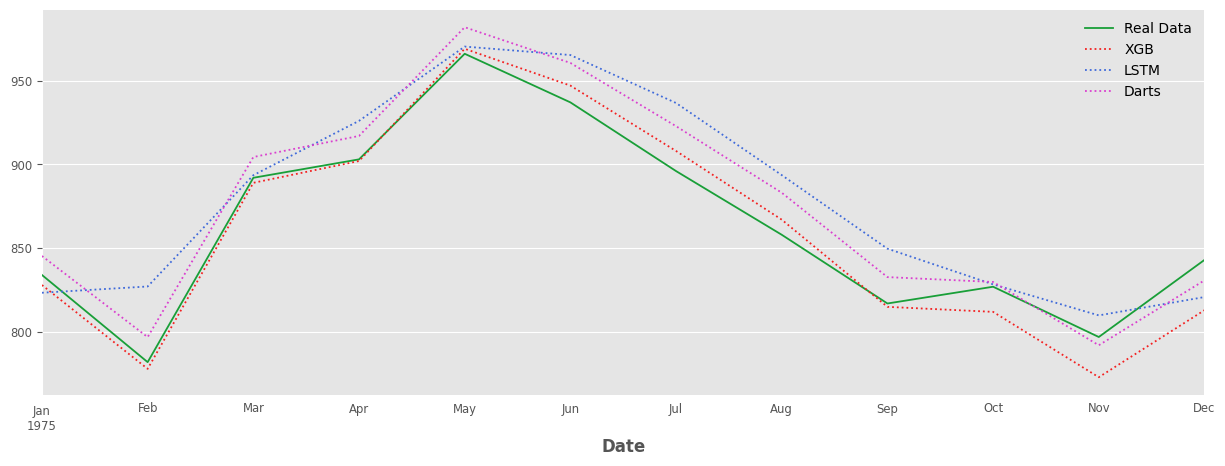

In [437]:
fig, ax = plt.subplots()

test_XGB["Production"].plot(ax = ax , label = "Test Values", color = "#199F38")
test_XGB["prediction"].plot(ax = ax, label = "XGB", color = "#F32121", linestyle = 'dotted')
test_LSTM["prediction"].plot(ax = ax, label = "LSTM", color = "#3F6ADA", linestyle = 'dotted')
test_darts["prediction"].plot(ax = ax, label = "Darts", color = "#DA3FCF", linestyle = 'dotted')
plt.legend(["Real Data", "XGB", "LSTM", "Darts"])
plt.show()

In [438]:
comparison = pd.DataFrame({
    "XGB" : pd.Series(rsme_XGB_dict),
    "LSTM" : pd.Series(rsme_LSTM_dict),
    "Darts" : pd.Series(rsme_darts_dict)
})

comparison

,XGB,LSTM,Darts
12,13.231994,33.741725,23.844404
24,21.239434,76.303778,23.844404
36,13.674879,100.955210,23.844404
48,23.458279,89.571124,23.844404
60,69.689915,112.214407,23.844404
72,80.228616,90.477858,23.844404


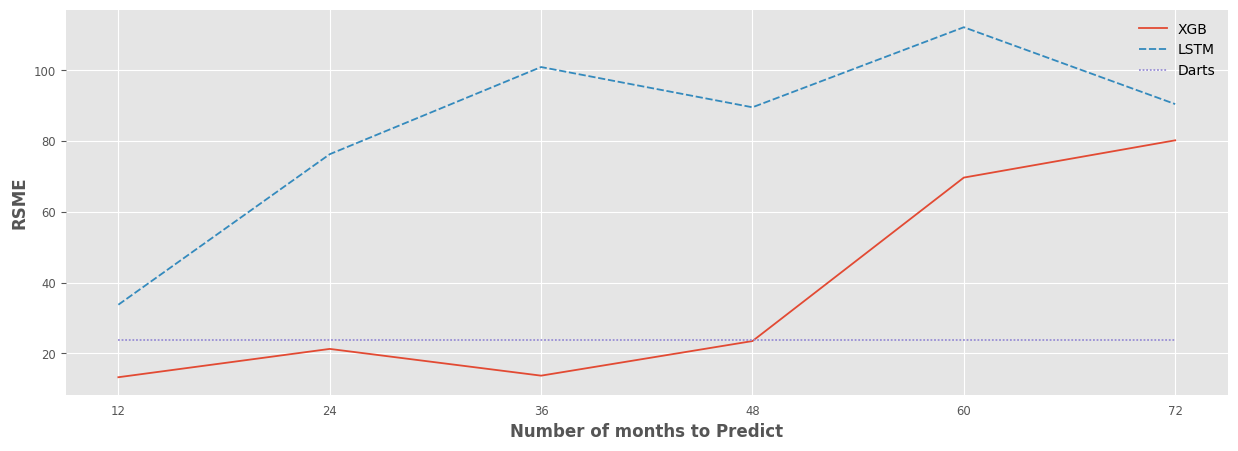

In [439]:
sns.lineplot(data = comparison[['XGB', 'LSTM', 'Darts']])
plt.xticks(date_list)
plt.ylabel("RSME")
plt.xlabel("Number of months to Predict")
plt.show()